# Investigating First Live Studies

## Lung Segmentation

Using Lungmask - https://github.com/JoHof/lungmask trained on diverse dataset for severe pathologies e.g. fibrosis

Limitations: The model works on full slices only. The slice to process has to show the full lung and the lung has to be surrounded by tissue in order to get segmented. However, the model is quite stable to cases with a cropped field of view as long as the lung is surrounded by tissue.

In [1]:
import pydicom
import SimpleITK as sitk
import radiomics
from radiomics import featureextractor
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from lungmask import LMInferer




Import image slice

In [2]:
image_path = '/Users/dhruvgupta/Documents/GitHub/BromptonML/ANON_8bb2a34a27bb4b1a8a450e2f185e830c/DIR000/00000002/00000200.DCM'
input_image = sitk.ReadImage(image_path)

Visualise

(512, 512)


(-0.5, 511.5, 511.5, -0.5)

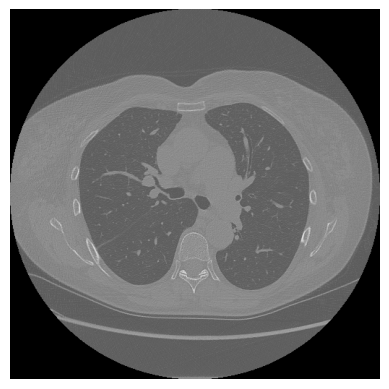

In [3]:
# Convert to a NumPy array
image_array = sitk.GetArrayFromImage(input_image)


# Remove the first dimension
image_array = np.squeeze(image_array)

print(image_array.shape)
# Display 2D Slice
plt.imshow(image_array, cmap="gray")
plt.axis("off")
#plt.show()

Run Segmentation alg

In [4]:
inferer = LMInferer()
segmentation = inferer.apply(input_image)  # default model is U-net(R231)

lungmask 2024-11-19 08:05:28 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


1it [00:00,  4.04it/s]                  

lungmask 2024-11-19 08:05:29 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 7577.79it/s]


Visualise Segmentation


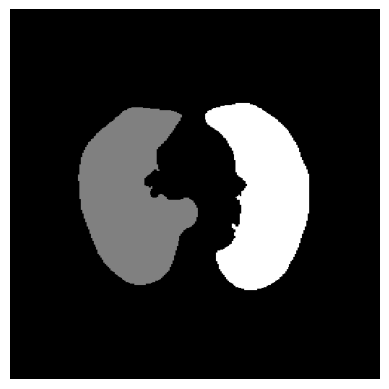

In [5]:
seg_array = np.squeeze(segmentation)


# Display 2D Slice
plt.imshow(seg_array, cmap="gray")
plt.axis("off")
plt.show()


In [6]:
np.unique(seg_array)

array([0, 1, 2], dtype=uint8)

Right Lung

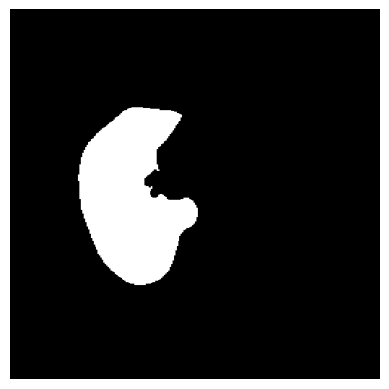

In [7]:
right_lung = np.where(seg_array == 2,0,seg_array)

# Display 2D Slice
plt.imshow(right_lung, cmap="gray")
plt.axis("off")
plt.show()

Left Lung

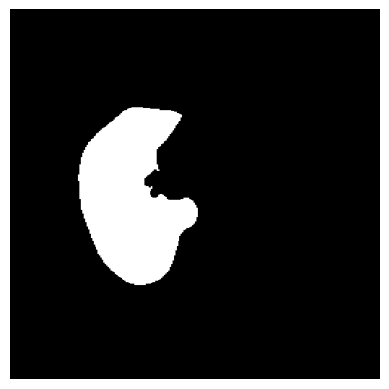

In [8]:
left_lung = np.where(seg_array == 2,0,seg_array)

# Display 2D Slice
plt.imshow(left_lung, cmap="gray")
plt.axis("off")
plt.show()

### Apply Mask to Original Image

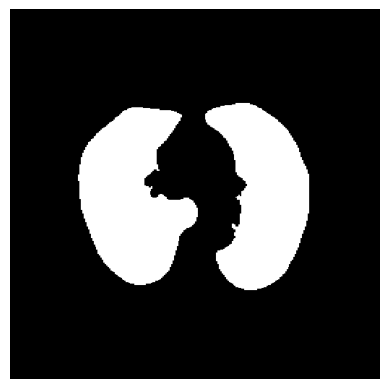

In [9]:
both_lungs = np.where(seg_array == 2,1, seg_array)

image_seg = np.matmul(image_array,both_lungs)

# Display 2D Slice
plt.imshow(both_lungs, cmap="gray")
plt.axis("off")
plt.show()

(-0.5, 511.5, 511.5, -0.5)

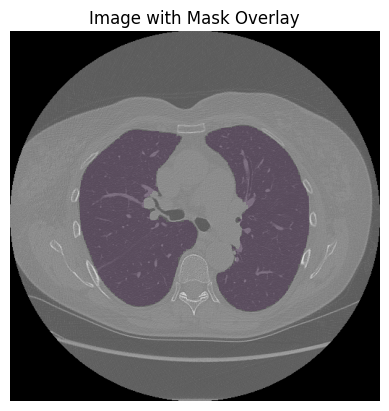

In [10]:
# Mask the zero values
masked_data = np.ma.masked_where(both_lungs == 0, both_lungs)

plt.imshow(image_array, cmap='grey')
plt.imshow(masked_data, cmap='viridis', alpha=0.2)  # Overlay with transparency
plt.title("Image with Mask Overlay")
plt.axis('off')

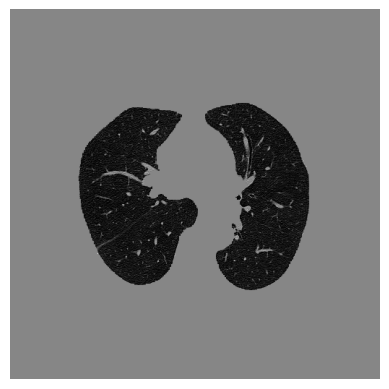

In [11]:
mask_lungs = np.where(both_lungs == 1, image_array,0)

# Display 2D Slice
plt.imshow(mask_lungs, cmap="grey")
plt.axis("off")
plt.show()

### Apply Segmentation on full 3D image


In [12]:
image_path3d = '/Users/dhruvgupta/Documents/GitHub/BromptonML/ANON_8bb2a34a27bb4b1a8a450e2f185e830c/DIR000/00000002'

# Load DICOM series from a directory
dicom_reader = sitk.ImageSeriesReader()
dicom_files = dicom_reader.GetGDCMSeriesFileNames(image_path3d)
dicom_reader.SetFileNames(dicom_files)
image_3d = dicom_reader.Execute()


In [13]:
seg_3d = inferer.apply(image_3d)

25it [00:11,  2.11it/s]                          

lungmask 2024-11-19 08:05:46 Postprocessing



100%|██████████| 19/19 [00:00<00:00, 71.25it/s] 


(-0.5, 511.5, 511.5, -0.5)

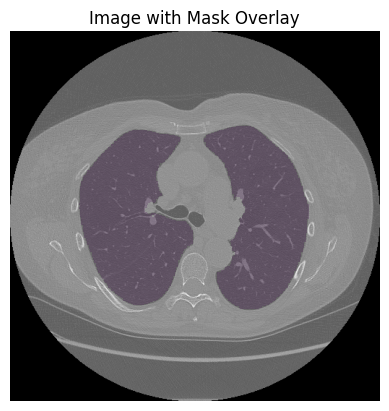

In [18]:
image_array3d = sitk.GetArrayFromImage(image_3d)

seg_3d = np.where(seg_3d == 2,1,seg_3d )

# Mask the zero values
masked_data3d = np.ma.masked_where(seg_3d == 0, seg_3d)

plt.imshow(image_array3d[300,:,:], cmap='grey')
plt.imshow(masked_data3d[300,:,:], cmap='viridis', alpha=0.2)  # Overlay with transparency
plt.title("Image with Mask Overlay")
plt.axis('off')


## Load Brompton Images

In [25]:
ONO077_path = '/Users/dhruvgupta/Library/CloudStorage/OneDrive-DMCHealthcare/Personal Drive/AI/Brompton_AI/ONO077/DICOM/P0000001/ST000001/SE000005'

PS049_path = '/Users/dhruvgupta/Library/CloudStorage/OneDrive-DMCHealthcare/Personal Drive/AI/Brompton_AI/PS049/PS049/1.2.840.113704.9.1000.16.1.2020091409593611900020002'

PS050_path = '/Users/dhruvgupta/Library/CloudStorage/OneDrive-DMCHealthcare/Personal Drive/AI/Brompton_AI/PS050/PS050/1.2.840.113619.2.428.3.671764512.829.1620882346.976.3'

VK101_path = '/Users/dhruvgupta/Library/CloudStorage/OneDrive-DMCHealthcare/Personal Drive/AI/Brompton_AI/VK101/10000627/10000628/10000629'

In [26]:

def loadImageSeries(path):

    dicom_reader = sitk.ImageSeriesReader()
    dicom_files = dicom_reader.GetGDCMSeriesFileNames(path)
    dicom_reader.SetFileNames(dicom_files)
    image_out = dicom_reader.Execute()

    return image_out

In [ ]:
ONO077_image = loadImageSeries(ONO077_path)
ONO077_array = sitk.GetArrayFromImage(ONO077_image)
ONO077_shape = ONO077_array.shape

PS049_image = loadImageSeries(PS049_path)
PS049_array = sitk.GetArrayFromImage(PS049_image)
PS049_shape = PS049_array.shape

PS050_image = loadImageSeries(PS050_path)
PS050_array = sitk.GetArrayFromImage(PS050_image)
PS050_shape = PS050_array.shape

VK101_image = loadImageSeries(VK101_path)
VK101_array = sitk.GetArrayFromImage(VK101_image)
VK101_shape = VK101_array.shape

View Slices of each study

Text(0.5, 1.0, 'VK101')

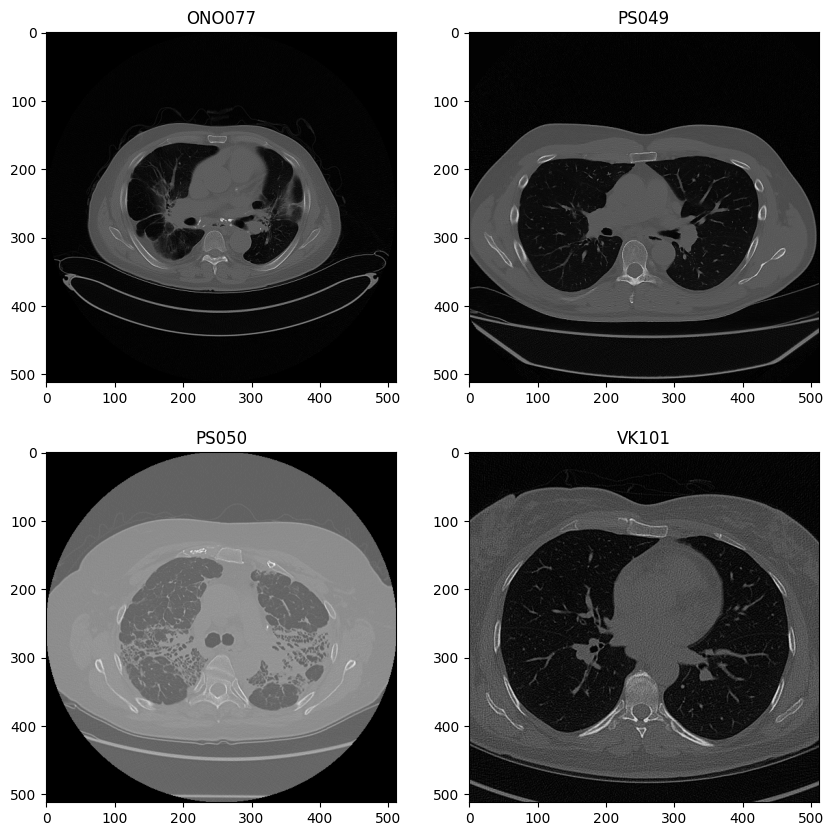

In [44]:
fig, axes = plt.subplots(2,2, figsize = (10,10))

axes[0,0].imshow(ONO077_array[30,:,:],cmap='grey')
axes[0,0].set_title('ONO077')

axes[0,1].imshow(PS049_array[300,:,:],cmap='grey')
axes[0,1].set_title('PS049')

axes[1,0].imshow(PS050_array[200,:,:],cmap='grey')
axes[1,0].set_title("PS050")

axes[1,1].imshow(VK101_array[200,:,:],cmap='grey')
axes[1,1].set_title("VK101")

Now apply normalisations - spacing, WL

In [46]:
print(ONO077_image.GetSpacing())
print(PS049_image.GetSpacing())
print(PS050_image.GetSpacing())
print(VK101_image.GetSpacing())

(0.9765625, 0.9765625, 5.0)
(0.794922, 0.794922, 1.0)
(0.732422, 0.732422, 1.25)
(0.541015625, 0.541015625, 0.7)


In [47]:
def image_down_sample(sitk_img, new_spacing):
    original_spacing = sitk_img.GetSpacing()
    resample_filter = sitk.ResampleImageFilter()
    resample_filter.SetDefaultPixelValue(0)
    resample_filter.SetOutputSpacing(new_spacing)
    resample_filter.SetSize([int(round(osz * ospc / nspc)) for osz, ospc, nspc in zip(sitk_img.GetSize(), original_spacing, new_spacing)])
    resample_filter.SetOutputDirection(sitk_img.GetDirection())
    resample_filter.SetOutputOrigin(sitk_img.GetOrigin())
    resample_filter.SetInterpolator(sitk.sitkLinear if sitk_img.GetPixelIDValue() != sitk.sitkUInt8 else sitk.sitkNearestNeighbor)

    resampled_img = resample_filter.Execute(sitk_img)
    return resampled_img


Text(0.5, 1.0, 'VK101')

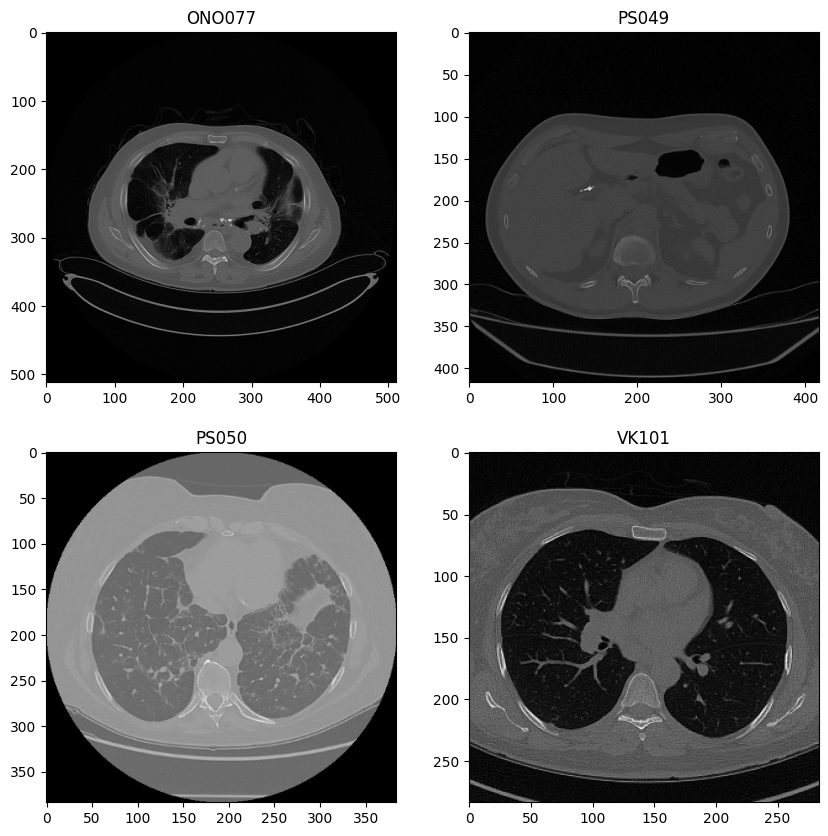

In [54]:
ONO077_norm = image_down_sample(ONO077_image,(0.9765625,0.9765625,5.0))
ONO077_norm_array = sitk.GetArrayFromImage(ONO077_norm)

PS049_norm = image_down_sample(PS049_image,(0.9765625,0.9765625,5.0))
PS049_norm_array = sitk.GetArrayFromImage(PS049_norm)

PS050_norm = image_down_sample(PS050_image,(0.9765625,0.9765625,5.0))
PS050_norm_array = sitk.GetArrayFromImage(PS050_norm)

VK101_norm = image_down_sample(VK101_image,(0.9765625,0.9765625,5.0))
VK101_norm_array = sitk.GetArrayFromImage(VK101_norm)

fig2, axes = plt.subplots(2,2, figsize = (10,10))

axes[0,0].imshow(ONO077_norm_array[30,:,:],cmap='grey')
axes[0,0].set_title('ONO077')

axes[0,1].imshow(PS049_norm_array[30,:,:],cmap='grey')
axes[0,1].set_title('PS049')

axes[1,0].imshow(PS050_norm_array[30,:,:],cmap='grey')
axes[1,0].set_title("PS050")

axes[1,1].imshow(VK101_norm_array[30,:,:],cmap='grey')
axes[1,1].set_title("VK101")